In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pickle
from scipy.ndimage import shift
from data_preprocess import load_and_preprocess_data

In [40]:
(train_x, train_y, test_x) = load_and_preprocess_data()

## Default model scores

In [41]:
dummy = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy, train_x, train_y, cv=10, scoring='r2')

In [42]:
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, train_x, train_y, cv=10, scoring='r2')

In [43]:
svm_pipe = make_pipeline(StandardScaler(), SVR())
svm_scores = cross_val_score(svm_pipe, train_x, train_y, cv=10, scoring='r2')

In [44]:
gb = HistGradientBoostingRegressor()
gb_scores = cross_val_score(gb, train_x, train_y, cv=10, scoring='r2')

In [45]:
gb = HistGradientBoostingRegressor()
gb_scores = cross_val_score(gb, train_x, train_y, cv=10, scoring='r2')

In [46]:
linear = LinearRegression()
linear_score = cross_val_score(linear, train_x, train_y, cv=10, scoring='r2')

In [50]:
degree = 2 
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(train_x)

poly_2_score = cross_val_score(LinearRegression(), X_poly, train_y, cv=10, scoring='r2')

In [51]:
degree = 3 
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(train_x)

poly_3_score = cross_val_score(LinearRegression(), X_poly, train_y, cv=10, scoring='r2')

In [59]:
models = ['dummy', 'RF', 'SVR', 'GB', 'Linear Regression', 'Polynomial degree 2', 'Polynomial degree 3']
scores = [np.mean(dummy_scores), np.mean(rf_scores), np.mean(svm_scores), np.mean(gb_scores), np.mean(linear_score), np.mean(poly_2_score), np.mean(poly_2_score)]
score_df = pd.DataFrame({'Models': models, 'Scores': scores})
print(score_df)

                Models        Scores
0                dummy -2.641821e-04
1                   RF  7.171608e-01
2                  SVR  7.460670e-01
3                   GB  7.436126e-01
4    Linear Regression  7.069825e-01
5  Polynomial degree 2 -1.026521e+10
6  Polynomial degree 3 -1.026521e+10


In [ ]:
train_pol = train_x.copy()

for column in train_pol.columns:
    if column != 'log_pSat_Pa':
        try:
            train_pol[column] = train_pol[column] ** 2
        except (ValueError, AttributeError):
            pass


## Feature selection

In [4]:
def feature_selection_forward_stepwise(
    model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
):
    features = X_train.columns.values
    fitted_features = []
    fitted_features_stepwise = []
    best_r2_score = 0
    mse_score = 0
    best_feature = None
    r2_scores = []
    mse_scores = []
    
    while features.size:
        for f in features:
            scores = cross_validate(model, X_train.loc[:, np.concatenate([fitted_features, [f]])], y_train, cv=5, scoring=['r2', 'neg_mean_squared_error'])
            if np.mean(scores['test_r2']) > best_r2_score:
                best_feature = f
                best_r2_score = np.mean(scores['test_r2'])
                mse_score = np.mean(scores['test_neg_mean_squared_error'])

        fitted_features.append(best_feature)
        features = features[~np.isin(features, fitted_features)]
        r2_scores.append(best_r2_score)
        mse_scores.append(mse_score)       
        best_r2_score = 0
        mse_score = 0
        best_feature = None
        fitted_features_stepwise.append(list(fitted_features))
    
    return {'fitted_features': fitted_features_stepwise, 'r2_scores': r2_scores, 'mse_scores': mse_scores}
        

In [5]:
def feature_selection_importance(
    feature_importances: pd.Series,
    rfr_model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
):
    r2_scores = []
    mse_scores = []
    
    for i in range(0, feature_importances.shape[0]):
        features = feature_importances.index[0:i+1].to_list()
        model = rfr_model.fit(X_train.loc[:, features], y_train)
        scores = cross_validate(model, X_train.loc[:, features], y_train, cv=5, scoring=['r2', 'neg_mean_squared_error'])
        r2_scores.append(np.mean(scores['test_r2']))
        mse_scores.append(np.mean(scores['test_neg_mean_squared_error']))

    return r2_scores, mse_scores

In [8]:
def get_feature_selection_result_df(res):
    r2_scores = res['r2_scores']
    mse_scores = res['mse_scores']
    added_feature = res['added_feature']

    feature_selection_results = pd.DataFrame({
    'Num of features': np.arange(1,32),
    'R2 score': r2_scores,
    'R2 changed': r2_scores - shift(r2_scores, 1),
    'MSE score': -np.array(mse_scores),
    'MSE changed': -np.array(mse_scores) - shift(-np.array(mse_scores), 1),
    'Feature added': added_feature
    })

    return feature_selection_results

In [23]:
def get_best_features(df):
    max_r2_row = df.loc[df['R2 score'].idxmax()]

    min_mse_row = df.loc[df['MSE score'].idxmin()]

    print(f"Maximum R2 score: {max_r2_row['R2 score']} (Number of features: {max_r2_row['Num of features']})")
    print(f"Minimum MSE score: {min_mse_row['MSE score']} (Number of features: {min_mse_row['Num of features']})")


### Random Forest

In [33]:
rf = RandomForestRegressor()
rf_fit = rf.fit(train_x, train_y)
rf_feature_importances = pd.Series(rf_fit.feature_importances_, index=train_x.columns)
rf_feature_importances = rf_feature_importances.sort_values(ascending=False)
print(rf_feature_importances)

NumHBondDonors                  4.708698e-01
NumOfC                          1.189465e-01
NumOfConf                       1.123003e-01
NumOfConfUsed                   5.490666e-02
NumOfAtoms                      5.445552e-02
MW                              2.501604e-02
hydroxyl (alkyl)                2.030140e-02
carbonylperoxynitrate           1.956291e-02
ketone                          1.705310e-02
carboxylic acid                 1.587598e-02
NumOfO                          1.378893e-02
aldehyde                        1.265868e-02
peroxide                        8.509646e-03
hydroperoxide                   8.502002e-03
carbonylperoxyacid              8.013892e-03
C=C (non-aromatic)              6.989875e-03
ester                           6.886577e-03
nitrate                         5.170865e-03
ether (alicyclic)               5.082747e-03
nitro                           4.413860e-03
NumOfN                          2.707517e-03
apin                            2.462113e-03
decane    

In [49]:
try:
    with open('../pickles/rf_feature_selection_results.pickle', 'rb') as handle:
        rf_feature_selection_results = pickle.load(handle)
        rf_r2_scores = rf_feature_selection_results['r2_scores']
        rf_mse_scores = rf_feature_selection_results['mse_scores']
except:
    (rf_r2_scores, rf_mse_scores) = feature_selection_importance(rf_feature_importances, RandomForestRegressor(), train_x, train_y)

rf_feature_selection_df = get_feature_selection_result_df({
    'r2_scores': rf_r2_scores, 'mse_scores': rf_mse_scores, 'added_feature': rf_feature_importances.index})
print(rf_feature_selection_df)


    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475095    0.475095   5.118038     5.118038   
1                 2  0.628553    0.153459   3.621746    -1.496291   
2                 3  0.543631   -0.084922   4.449853     0.828106   
3                 4  0.562041    0.018410   4.270527    -0.179325   
4                 5  0.607949    0.045909   3.823076    -0.447451   
5                 6  0.632016    0.024067   3.588535    -0.234541   
6                 7  0.662422    0.030406   3.291775    -0.296760   
7                 8  0.672152    0.009730   3.196825    -0.094950   
8                 9  0.685199    0.013047   3.069630    -0.127195   
9                10  0.692731    0.007532   2.996277    -0.073353   
10               11  0.693399    0.000667   2.989763    -0.006514   
11               12  0.694852    0.001453   2.975504    -0.014259   
12               13  0.701547    0.006695   2.910171    -0.065333   
13               14  0.704043    0

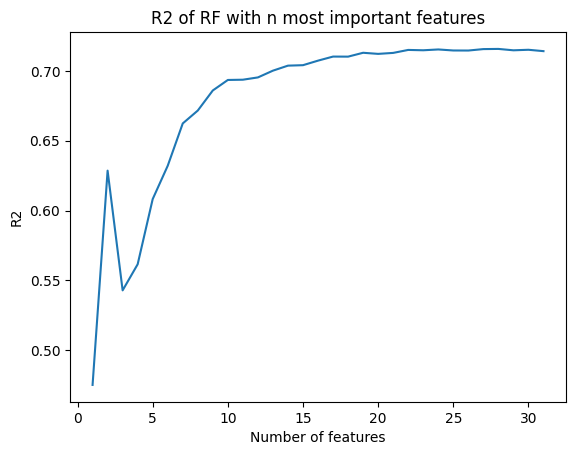

In [71]:
plt.plot(np.arange(1,32), rf_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of RF with n most important features')
plt.show()

In [31]:
try:
    with open('../pickles/rf_forward_stepwise_feature_selection_results.pickle', 'rb') as handle:
        res = pickle.load(handle)
except:
    res = feature_selection_forward_stepwise(RandomForestRegressor(), train_x, train_y)

rf_fs_r2_scores = res['r2_scores']
rf_fs_mse_scores = res['mse_scores']
rf_fs_fitted_features = res['fitted_features']

rf_forward_stepwise_result_df = get_feature_selection_result_df({
    'r2_scores': rf_fs_r2_scores, 'mse_scores': rf_fs_mse_scores, 'added_feature': [x[len(x) - 1] for x in rf_fs_fitted_features]}) 
print(rf_forward_stepwise_result_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475214    0.475214   5.117586     5.117586   
1                 2  0.631022    0.155808   3.598225    -1.519362   
2                 3  0.647124    0.016102   3.441274    -0.156950   
3                 4  0.652566    0.005442   3.388053    -0.053221   
4                 5  0.661040    0.008474   3.305433    -0.082620   
5                 6  0.666836    0.005796   3.248998    -0.056435   
6                 7  0.671659    0.004824   3.201970    -0.047028   
7                 8  0.673940    0.002280   3.179734    -0.022237   
8                 9  0.674891    0.000951   3.170466    -0.009267   
9                10  0.674383   -0.000507   3.175396     0.004930   
10               11  0.675052    0.000669   3.168917    -0.006480   
11               12  0.675285    0.000232   3.166625    -0.002292   
12               13  0.675299    0.000015   3.166525    -0.000100   
13               14  0.674882   -0

### Support Vector Regression

In [53]:
try:
    with open('../pickles/svm_feature_importances.pickle', 'rb') as handle:
        svm_feature_importances = pickle.load(handle)
except:
    svm_pipe = make_pipeline(StandardScaler(), SVR())
    svm_pipe.fit(train_x, train_y)
    svm_feature_importances = permutation_importance(svm_pipe, train_x, train_y, n_repeats=10, random_state=0)

svm_feature_importance_means = svm_feature_importances.importances_mean
svm_feature_importance_means = pd.Series(svm_feature_importance_means, index=train_x.columns)
svm_feature_importance_means = svm_feature_importance_means.sort_values(ascending=False)
print(svm_feature_importance_means)

NumOfC                          0.315979
NumHBondDonors                  0.248728
NumOfConf                       0.108924
carboxylic acid                 0.099817
hydroperoxide                   0.052929
carbonylperoxyacid              0.043543
peroxide                        0.039652
NumOfAtoms                      0.037386
hydroxyl (alkyl)                0.034224
NumOfConfUsed                   0.028502
carbonylperoxynitrate           0.027450
ketone                          0.027021
NumOfO                          0.026989
MW                              0.025805
C=C (non-aromatic)              0.018720
ether (alicyclic)               0.017582
aldehyde                        0.014066
apin                            0.012137
decane                          0.009644
ester                           0.008706
NumOfN                          0.007333
nitrate                         0.006944
nitro                           0.005804
C=C-C=O in non-aromatic ring    0.004538
toluene         

In [54]:
try:
    with open('../pickles/svm_feature_selection_results.pickle', 'rb') as handle:
        svm_feature_selection_results = pickle.load(handle)
        svm_r2_scores = svm_feature_selection_results['r2_scores']
        svm_mse_scores = svm_feature_selection_results['mse_scores']
except:
    (svm_r2_scores, svm_mse_scores) = feature_selection_importance(svm_feature_importance_means, make_pipeline(StandardScaler(), SVR()), train_x, train_y)

svm_feature_selection_df = get_feature_selection_result_df({
    'r2_scores': svm_r2_scores, 'mse_scores': svm_mse_scores, 'added_feature': svm_feature_importance_means.index})
get_best_features(svm_feature_selection_df)

Maximum R2 score: 0.7472872629658561 (Number of features: 22)
Minimum MSE score: 2.464133856104536 (Number of features: 22)


In [55]:
svm_feature_selection_df

,Num of features,R2 score,R2 changed,MSE score,MSE changed,Feature added
0,1,0.114006,0.114006,8.639077,8.639077,NumOfC
1,2,0.626907,0.512901,3.637674,-5.001403,NumHBondDonors
2,3,0.647542,0.020636,3.436660,-0.201014,NumOfConf
3,4,0.667883,0.020341,3.238257,-0.198403,carboxylic acid
4,5,0.672154,0.004271,3.196573,-0.041684,hydroperoxide
5,6,0.681102,0.008948,3.109416,-0.087156,carbonylperoxyacid
6,7,0.687214,0.006112,3.049871,-0.059545,peroxide
7,8,0.694752,0.007539,2.976335,-0.073537,NumOfAtoms
8,9,0.694223,-0.000529,2.981482,0.005148,hydroxyl (alkyl)
9,10,0.701478,0.007255,2.910683,-0.070800,NumOfConfUsed


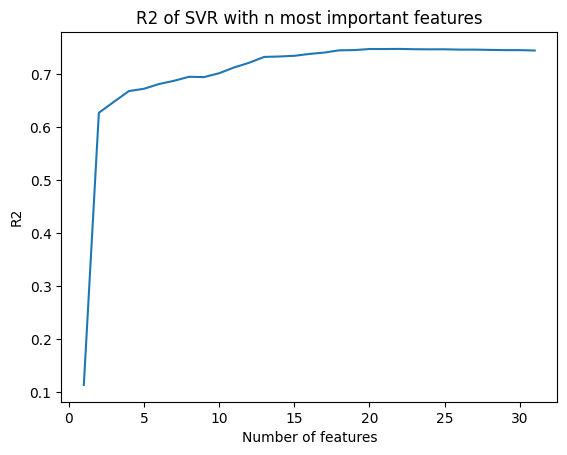

In [21]:
plt.plot(np.arange(1,32), svm_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of SVR with n most important features')
plt.show()

In [29]:
try:
    with open('../pickles/svm_forward_stepwise_feature_selection_results.pickle', 'rb') as handle:
        res = pickle.load(handle)
except:
    res = feature_selection_forward_stepwise(make_pipeline(StandardScaler(), SVR()), train_x, train_y)

svm_fs_r2_scores = res['r2_scores']
svm_fs_mse_scores = res['mse_scores']
svm_fs_fitted_features = res['fitted_features']

svm_forward_stepwise_result_df = get_feature_selection_result_df({
    'r2_scores': svm_fs_r2_scores, 'mse_scores': svm_fs_mse_scores, 'added_feature': [x[len(x) - 1] for x in svm_fs_fitted_features]}) 
get_best_features(svm_forward_stepwise_result_df)

Maximum R2 score: 0.7476303671266554 (Number of features: 22)
Minimum MSE score: 2.460753769303193 (Number of features: 22)


In [31]:
svm_forward_stepwise_result_df


,Num of features,R2 score,R2 changed,MSE score,MSE changed,Feature added
0,1,0.474957,0.474957,5.119358,5.119358,NumHBondDonors
1,2,0.626907,0.151949,3.637674,-1.481684,NumOfC
2,3,0.653759,0.026853,3.376099,-0.261574,hydroxyl (alkyl)
3,4,0.670325,0.016566,3.214629,-0.161471,NumOfConf
4,5,0.686462,0.016137,3.057326,-0.157302,carbonylperoxynitrate
5,6,0.695802,0.009340,2.966285,-0.091041,apin
6,7,0.703526,0.007723,2.890990,-0.075295,ketone
7,8,0.711910,0.008384,2.809260,-0.081731,NumOfO
8,9,0.720197,0.008287,2.728517,-0.080742,peroxide
9,10,0.725601,0.005404,2.675807,-0.052710,NumOfAtoms


### Gradient Boosting

In [6]:
try:
    with open('../pickles/gb_feature_importances.pickle', 'rb') as handle:
        gb_feature_importances = pickle.load(handle)
except:
    gb = HistGradientBoostingRegressor()
    gb.fit(train_x, train_y)
    gb_feature_importances = permutation_importance(gb, train_x, train_y, n_repeats=30, random_state=0)

gb_feature_importance_means = gb_feature_importances.importances_mean
gb_feature_importance_means = pd.Series(gb_feature_importance_means, index=train_x.columns)
gb_feature_importance_means = gb_feature_importance_means.sort_values(ascending=False)
print(gb_feature_importance_means)

NumHBondDonors                  0.579891
NumOfC                          0.194672
NumOfConf                       0.146375
carbonylperoxynitrate           0.043520
NumOfConfUsed                   0.035205
carboxylic acid                 0.031621
peroxide                        0.028846
ketone                          0.019975
hydroxyl (alkyl)                0.016425
C=C (non-aromatic)              0.011693
NumOfO                          0.011649
aldehyde                        0.009638
ether (alicyclic)               0.009624
NumOfAtoms                      0.008656
ester                           0.007764
carbonylperoxyacid              0.007314
MW                              0.007097
apin                            0.005561
decane                          0.005146
hydroperoxide                   0.005018
toluene                         0.002488
NumOfN                          0.002435
nitro                           0.001980
nitrate                         0.001524
C=C-C=O in non-a

In [12]:
try:
    with open('../pickles/gb_feature_selection_results.pickle', 'rb') as handle:
        gb_feature_selection_results = pickle.load(handle)
        gb_r2_scores = gb_feature_selection_results['r2_scores']
        gb_mse_scores = gb_feature_selection_results['mse_scores']
except:
    gb_r2_scores, gb_mse_scores = feature_selection_importance(gb_feature_importance_means, HistGradientBoostingRegressor(), train_x, train_y)

gb_feature_selection_df = get_feature_selection_result_df({
    'r2_scores': gb_r2_scores, 'mse_scores': gb_mse_scores, 'added_feature': gb_feature_importance_means.index})
print(gb_feature_selection_df['MSE score'].min())

2.503509410817394


In [30]:
try:
    with open('../pickles/gb_forward_stepwise_feature_selection_results.pickle', 'rb') as handle:
        res = pickle.load(handle)
except:
    gb_fs_res = feature_selection_forward_stepwise(HistGradientBoostingRegressor(), train_x, train_y)

gb_fs_r2_scores = gb_fs_res['r2_scores']
gb_fs_mse_scores = gb_fs_res['mse_scores']
gb_fs_fitted_features = gb_fs_res['fitted_features']

gb_forward_stepwise_result_df = get_feature_selection_result_df({
    'r2_scores': gb_fs_r2_scores, 'mse_scores': gb_fs_mse_scores, 'added_feature': [x[len(x) - 1] for x in gb_fs_fitted_features]}) 
print(gb_forward_stepwise_result_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475125    0.475125   5.117735     5.117735   
1                 2  0.627836    0.152711   3.628670    -1.489066   
2                 3  0.654610    0.026774   3.367825    -0.260845   
3                 4  0.671568    0.016958   3.202523    -0.165302   
4                 5  0.688565    0.016997   3.036864    -0.165658   
5                 6  0.696835    0.008270   2.956111    -0.080753   
6                 7  0.703659    0.006824   2.889476    -0.066636   
7                 8  0.710066    0.006407   2.827023    -0.062453   
8                 9  0.717183    0.007116   2.757687    -0.069336   
9                10  0.723451    0.006268   2.696704    -0.060983   
10               11  0.728669    0.005219   2.645872    -0.050832   
11               12  0.732063    0.003394   2.612765    -0.033107   
12               13  0.735257    0.003194   2.581626    -0.031139   
13               14  0.737487    0

## Pickle some stuff

In [40]:
with open('../pickles/svm_feature_importances.pickle', 'wb+') as handle:
    pickle.dump(svm_feature_importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open('../pickles/gb_feature_importances.pickle', 'wb+') as handle:
    pickle.dump(gb_feature_importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
with open('../pickles/svm_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_scores': svm_r2_scores, 'mse_scores': svm_mse_scores}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('../pickles/gb_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_scores': gb_r2_scores, 'mse_scores': gb_mse_scores}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('../pickles/rf_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_scores': rf_r2_scores, 'mse_scores': rf_mse_scores}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('../pickles/gb_forward_stepwise_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'fitted_features': gb_fs_res['fitted_features'], 'r2_scores': gb_fs_res['r2_scores'], 'mse_scores': gb_fs_res['mse_scores']}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open('../pickles/svm_forward_stepwise_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'fitted_features': res['fitted_features'], 'r2_scores': res['r2_scores'], 'mse_scores': res['mse_scores']}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('../pickles/rf_forward_stepwise_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'fitted_features': res['fitted_features'], 'r2_scores': res['r2_scores'], 'mse_scores': res['mse_scores']}, handle, protocol=pickle.HIGHEST_PROTOCOL)